In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve


In [15]:
with open('models/model_linear', 'rb') as f:
    model_linear = pickle.load(f)

In [16]:
print(model_linear)

LinearRegression()


In [17]:
df = pd.read_csv('data/fifa_players_preprocessed.csv')

n_features = [
    'height_cm', 'weight_kg', 'weak_foot', 'skill_moves',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'potential', 'height_weight_ratio', 'primary_position_enc'
]
c_features = [col for col in df.columns if
              col.startswith("work_rate_") or col.startswith("preferred_foot_") or col.startswith("age_group_")]
features = n_features + c_features

X = df[features]
y_reg = df["value_eur"]
y_clf = df["high_value"]

scaler = StandardScaler()
X[n_features] = scaler.fit_transform(X[n_features])

X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

C:\Users\user\AppData\Local\Temp\ipykernel_32604\3771838512.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[n_features] = scaler.fit_transform(X[n_features])


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = model_linear.predict(X_train)
y_test_pred = model_linear.predict(X_test)
y_train_pred_eur = np.expm1(y_train_pred)
y_test_pred_eur = np.expm1(y_test_pred)

train_r2 = r2_score(y_train, y_train_pred_eur)
test_r2 = r2_score(y_test, y_test_pred_eur)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_eur))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_eur))

print("Train R2:", train_r2)
print("Test R2:", test_r2)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train R2: 0.7047574032900039
Test R2: 0.727668960543327
Train RMSE: 484733.132144992
Test RMSE: 471441.71263662376


In [19]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 50, 100]}
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 50]}

In [20]:
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=-1)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
ridge_grid.fit(X_train, y_train_log)

print("Best Ridge alpha:", ridge_grid.best_params_)
y_train_pred_ridge_log = ridge_grid.predict(X_train)
y_test_pred_ridge_log = ridge_grid.predict(X_test)

y_train_pred_ridge = np.expm1(y_train_pred_ridge_log)
y_test_pred_ridge = np.expm1(y_test_pred_ridge_log)

print("Ridge R² Train:", r2_score(y_train, y_train_pred_ridge))
print("Ridge R² Test:", r2_score(y_test, y_test_pred_ridge))
print("Ridge RMSE Train:", np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))
print("Ridge RMSE Test:", np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))


Best Ridge alpha: {'alpha': 10}
Ridge R² Train: 0.7028586802688959
Ridge R² Test: 0.7263192613301765
Ridge RMSE Train: 486289.3082545675
Ridge RMSE Test: 472608.5242874398


In [21]:
lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_grid.fit(X_train, y_train_log)

print("Best Lasso alpha:", lasso_grid.best_params_)

y_train_pred_log = lasso_grid.predict(X_train)
y_test_pred_log = lasso_grid.predict(X_test)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

print("Lasso Regression Results:")
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))



Best Lasso alpha: {'alpha': 0.001}
Lasso Regression Results:
Train R²: 0.7013346437674128
Test R²: 0.726200061472067
Train RMSE: 487534.801110122
Test RMSE: 472711.4338611545


In [36]:
data = [
    ["Linear", 0.7048, 0.7277, 484733, 471442],
    ["Ridge (α=10)", 0.7029, 0.7263, 486289, 472609],
    ["Lasso (α=0.001)", 0.7013, 0.7262, 487535, 472711]
]

df_reg = pd.DataFrame(data, columns=["Model", "Train_R2", "Test_R2", "Train_RMSE", "Test_RMSE"])
df_reg

,Model,Train_R2,Test_R2,Train_RMSE,Test_RMSE
0,Linear,0.7048,0.7277,484733,471442
1,Ridge (α=10),0.7029,0.7263,486289,472609
2,Lasso (α=0.001),0.7013,0.7262,487535,472711


In [37]:
df_reg.idxmax()

Model         1
Train_R2      0
Test_R2       0
Train_RMSE    2
Test_RMSE     2
dtype: int64

Best SVR params: {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}
SVR R² Train: 0.8997248763224703
SVR R² Test: 0.8703274986252572
SVR RMSE Train: 282494.37219669006
SVR RMSE Test: 325314.46774976974


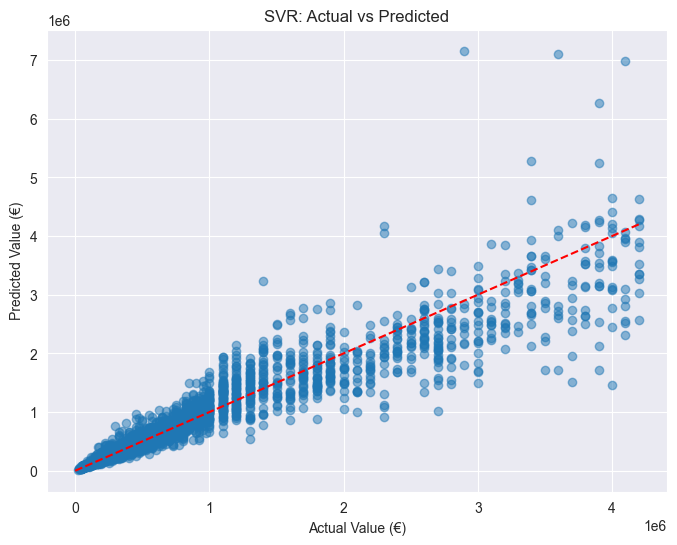

In [22]:
svr = SVR(kernel='rbf')

svr_params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.1, 0.5, 1]
}

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='r2', n_jobs=-1)
svr_grid.fit(X_train, y_train_log)

print("Best SVR params:", svr_grid.best_params_)

y_train_pred_log = svr_grid.predict(X_train)
y_test_pred_log = svr_grid.predict(X_test)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

print("SVR R² Train:", r2_score(y_train, y_train_pred))
print("SVR R² Test:", r2_score(y_test, y_test_pred))
print("SVR RMSE Train:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("SVR RMSE Test:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([0, y_reg.max()], [0, y_reg.max()], '--', color='red')
plt.xlabel("Actual Value (€)")
plt.ylabel("Predicted Value (€)")
plt.title("SVR: Actual vs Predicted")
plt.show()


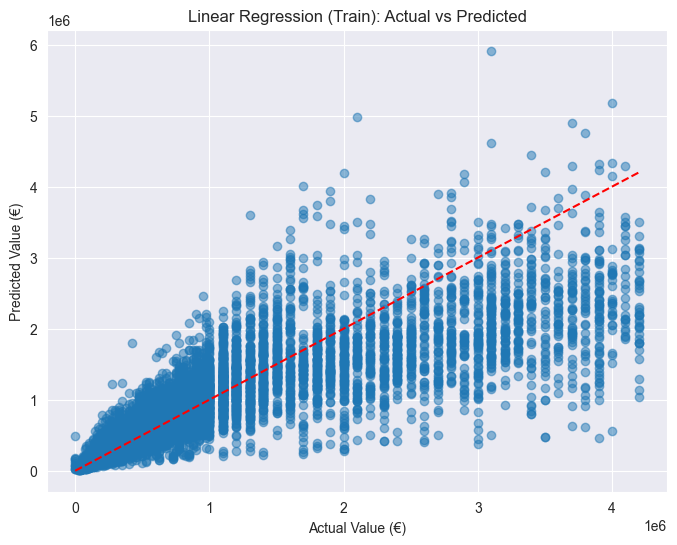

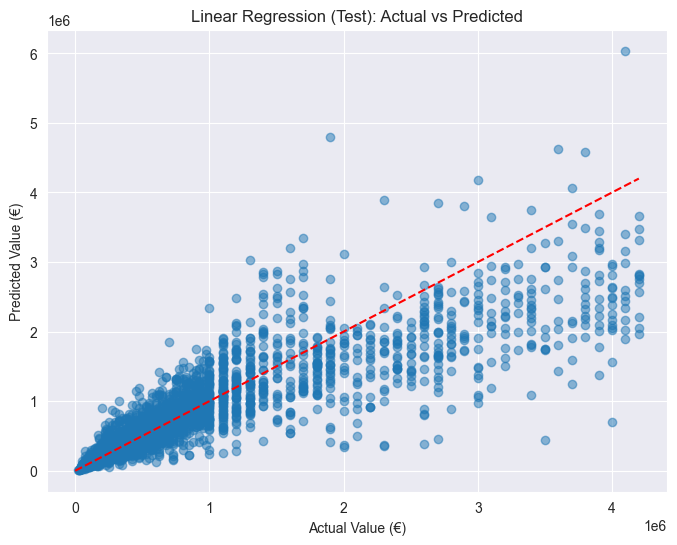

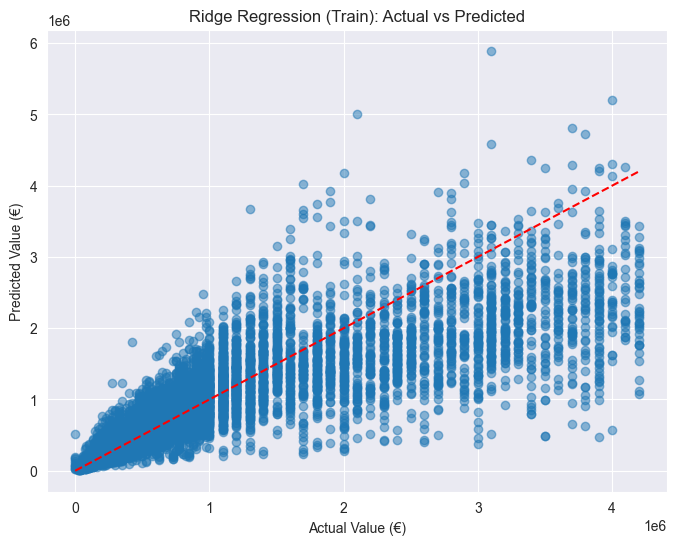

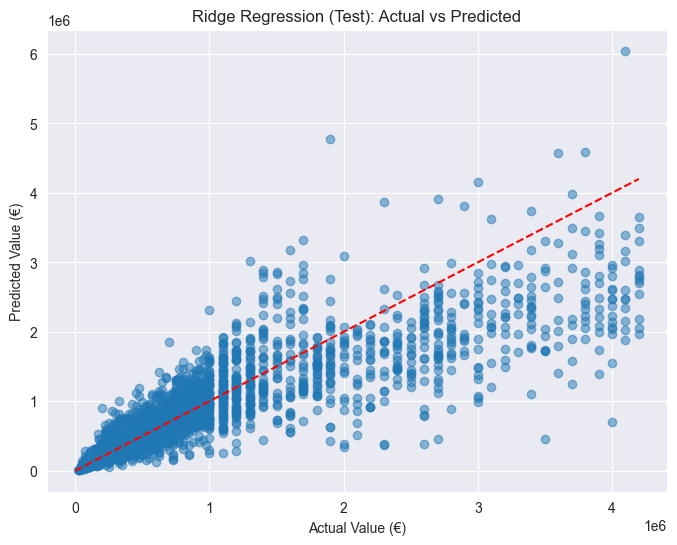

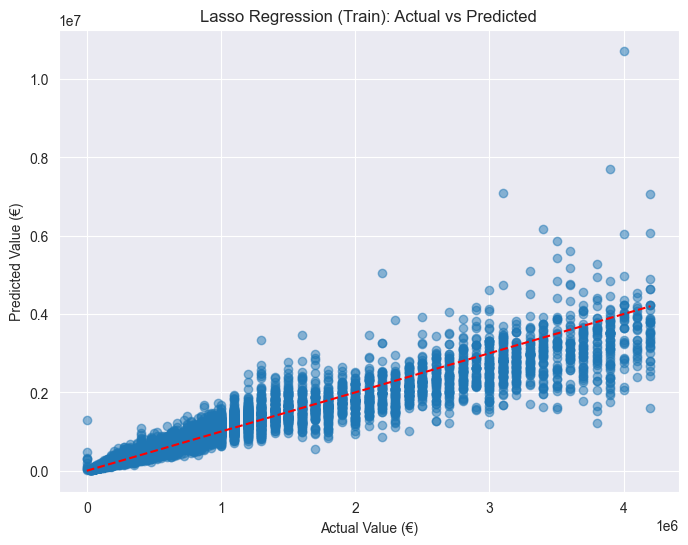

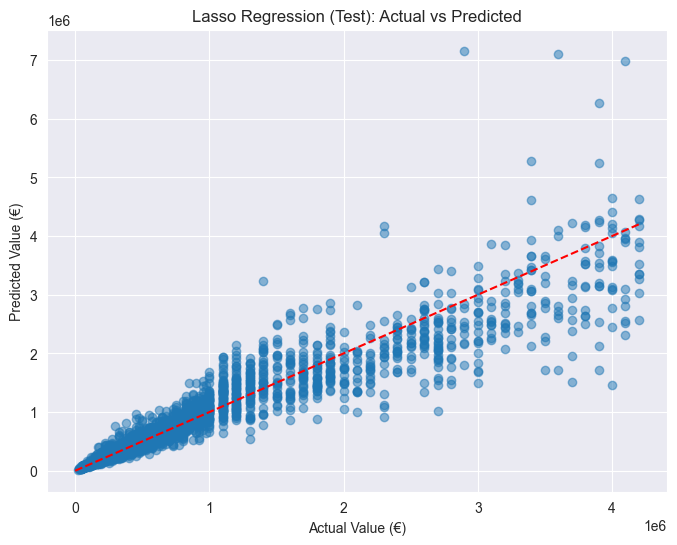

In [23]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([0, y_true.max()], [0, y_true.max()], '--', color='red')
    plt.xlabel("Actual Value (€)")
    plt.ylabel("Predicted Value (€)")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.show()


plot_predictions(y_train, y_train_pred_eur, "Linear Regression (Train)")
plot_predictions(y_test, y_test_pred_eur, "Linear Regression (Test)")
print("="*80)
plot_predictions(y_train, y_train_pred_ridge, "Ridge Regression (Train)")
plot_predictions(y_test, y_test_pred_ridge, "Ridge Regression (Test)")
print("="*80)
plot_predictions(y_train, y_train_pred, "Lasso Regression (Train)")
plot_predictions(y_test, y_test_pred, "Lasso Regression (Test)")

====================================================================

In [24]:
with open('models/model_logistic', 'rb') as f:
    model_logistic = pickle.load(f)
X_train, X_test, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)

Train Accuracy: 0.9020087336244541
Test Accuracy: 0.9042961928047503
Train Precision: 0.8831805585163078
Test Precision: 0.8902127659574468
Train Recall: 0.878312486750053
Test Recall: 0.8782535684298909
Train F1: 0.8807397959183674
Test F1: 0.8841927303465765


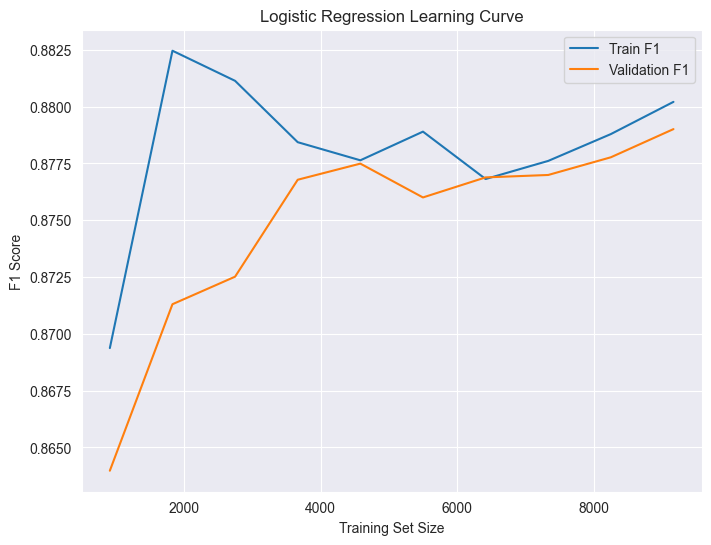

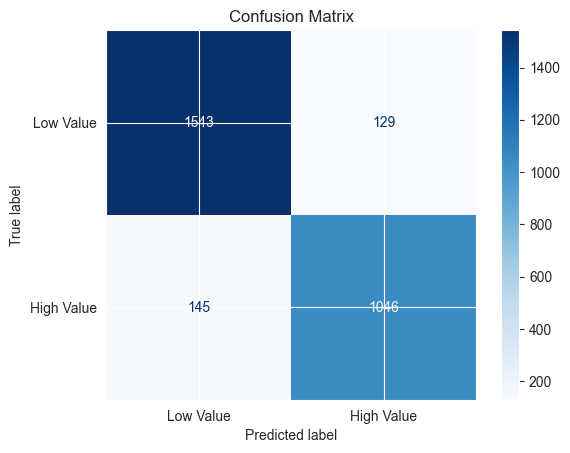

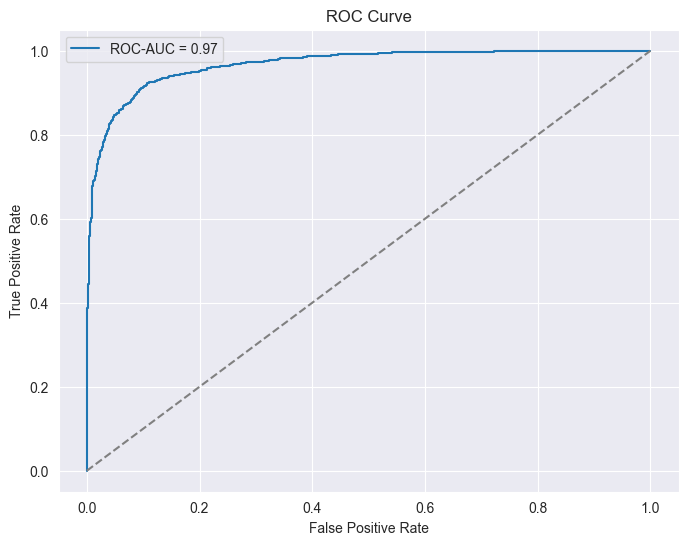

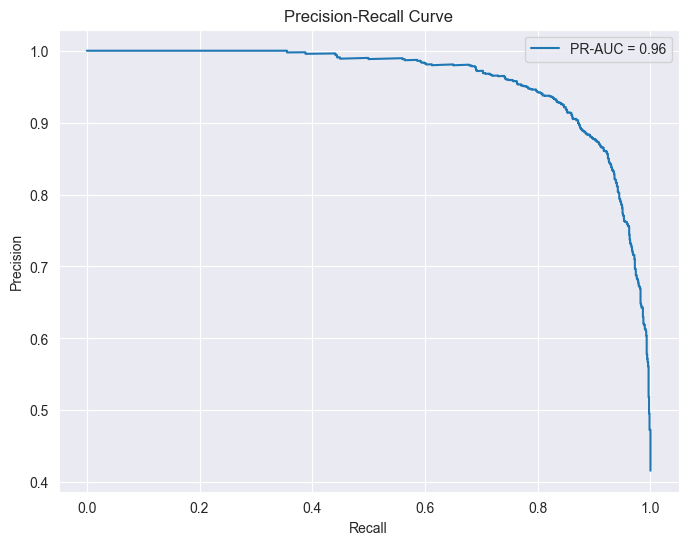

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

y_train_pred = model_logistic.predict(X_train)
y_test_pred = model_logistic.predict(X_test)

y_train_probs = model_logistic.predict_proba(X_train)[:,1]
y_test_probs = model_logistic.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Train Accuracy:", accuracy_score(y_clf_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_clf_test, y_test_pred))
print("Train Precision:", precision_score(y_clf_train, y_train_pred))
print("Test Precision:", precision_score(y_clf_test, y_test_pred))
print("Train Recall:", recall_score(y_clf_train, y_train_pred))
print("Test Recall:", recall_score(y_clf_test, y_test_pred))
print("Train F1:", f1_score(y_clf_train, y_train_pred))
print("Test F1:", f1_score(y_clf_test, y_test_pred))

from sklearn.model_selection import learning_curve
import numpy as np
train_sizes, train_scores, val_scores = learning_curve(
    model_logistic, X_train, y_clf_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1', n_jobs=-1
)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train F1')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Logistic Regression Learning Curve")
plt.legend()
plt.show()

cm = confusion_matrix(y_clf_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Low Value', 'High Value'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_clf_test, y_test_probs)
fpr, tpr, _ = roc_curve(y_clf_test, y_test_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [26]:
from sklearn.linear_model import LogisticRegression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 50],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_clf_train)

best_model = grid.best_estimator_
print("Best hyperparameters:", grid.best_params_)

Best hyperparameters: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}


In [27]:

def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model"):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_probs = model.predict_proba(X_train)[:,1]
    y_test_probs = model.predict_proba(X_test)[:,1]

    # Metrics
    print(f"==== {name} ====")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Train Precision:", precision_score(y_train, y_train_pred))
    print("Test Precision:", precision_score(y_test, y_test_pred))
    print("Train Recall:", recall_score(y_train, y_train_pred))
    print("Test Recall:", recall_score(y_test, y_test_pred))
    print("Train F1:", f1_score(y_train, y_train_pred))
    print("Test F1:", f1_score(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Low Value', 'High Value'])
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    roc_auc = roc_auc_score(y_test, y_test_probs)
    fpr, tpr, _ = roc_curve(y_test, y_test_probs)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.show()

==== Original Logistic Regression ====
Train Accuracy: 0.9020087336244541
Test Accuracy: 0.9042961928047503
Train Precision: 0.8831805585163078
Test Precision: 0.8902127659574468
Train Recall: 0.878312486750053
Test Recall: 0.8782535684298909
Train F1: 0.8807397959183674
Test F1: 0.8841927303465765


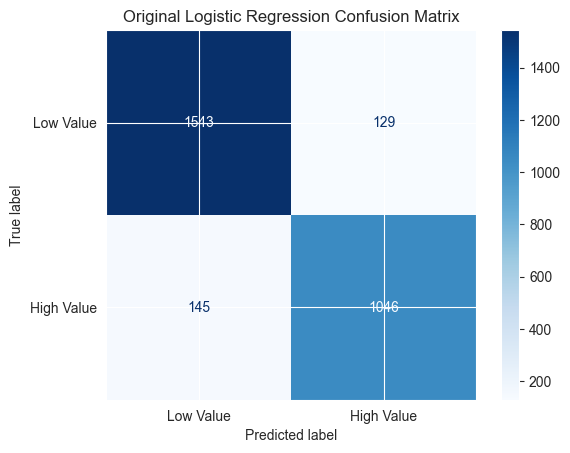

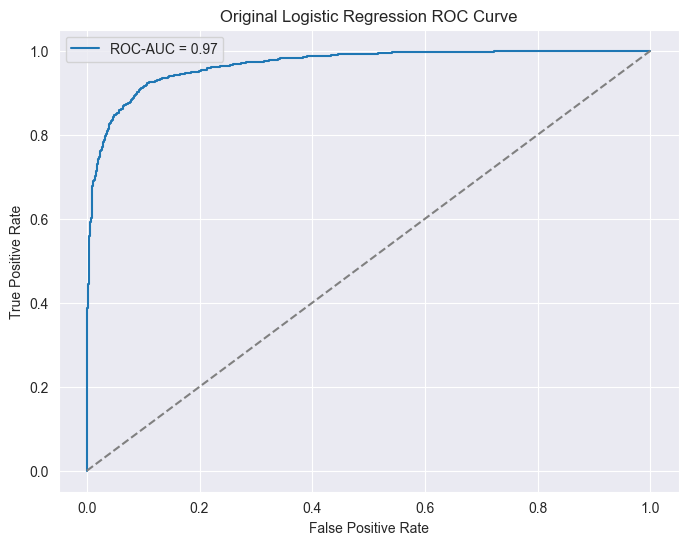

==== Tuned Logistic Regression ====
Train Accuracy: 0.902707423580786
Test Accuracy: 0.9053440447083478
Train Precision: 0.8837060702875399
Test Precision: 0.8938356164383562
Train Recall: 0.8795844816620734
Test Recall: 0.8765743073047859
Train F1: 0.8816404589885253
Test F1: 0.8851208139041967


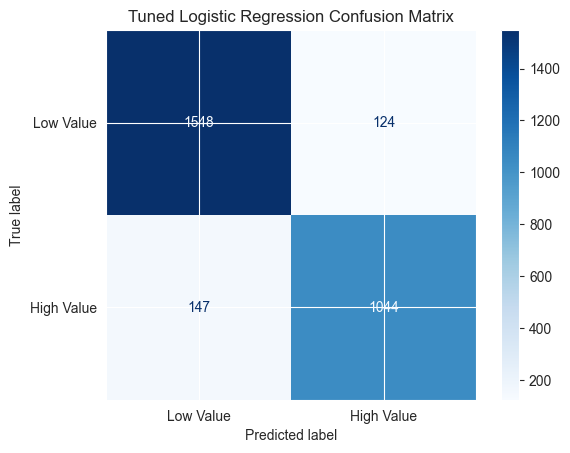

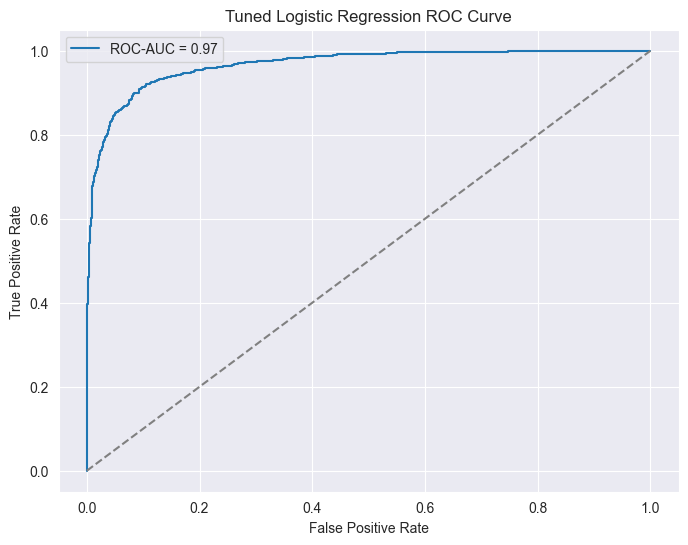

In [28]:
# Original model
evaluate_model(model_logistic, X_train, X_test, y_clf_train, y_clf_test, name="Original Logistic Regression")

# Tuned model
evaluate_model(best_model, X_train, X_test, y_clf_train, y_clf_test, name="Tuned Logistic Regression")


In [31]:

def get_metrics(model, X_train, X_test, y_train, y_test, name="Model"):
    y_test_pred = model.predict(X_test)
    y_test_probs = model.predict_proba(X_test)[:,1]

    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),

    }

In [35]:

results = []

# original model
results.append(get_metrics(model_logistic, X_train, X_test, y_clf_train, y_clf_test, name="Original"))

# tuned model
results.append(get_metrics(best_model, X_train, X_test, y_clf_train, y_clf_test, name="Tuned"))

df_results = pd.DataFrame(results)
df_results

,model,accuracy,precision,recall,f1
0,Original,0.904296,0.890213,0.878254,0.884193
1,Tuned,0.905344,0.893836,0.876574,0.885121


In [34]:
df_results.idxmax()

model        1
accuracy     1
precision    1
recall       0
f1           1
dtype: int64